In [31]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

In [32]:
TRAIN_DATASET_PATH = 'train.csv'
VALID_DATASET_PATH = 'test.csv'  # Проверочный набор данных
MY_RANDOM_STATE = 29

**Описание набора данных**

In [33]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, delimiter=',')

In [34]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

**Основные классы, функции**

In [35]:
class DataPreprocessing():
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        
        self.medians=None
        self.life_square_median = None        
        self.kitchen_square_median = None        
        self.rooms_median = None
        self.floor_median = None
        self.house_year_median = None
        
        self.min_kitchen_square = 5
        self.max_house_floor = 40
        
    def fit(self, df):
        """Сохранение статистик"""

        # ----- Square --------------------------------------------
        
        # Общая площадь - ключевой показатель. Если он введен неправильно, то это очень плохо.
        # Будем отбрасывать все строки с общей площадью менее 8 кв.м. и более 200 кв.м.
        
        conditions = df.loc[(df['Square'] < 8) | (df['Square'] > 200)].index
        df.drop(conditions, inplace=True)

        # Показатели
        
        self.medians = df.median()
        
        self.life_square_median = df['LifeSquare'].quantile(0.5)
        self.kitchen_square_median = df['LifeSquare'].quantile(0.5)
        self.rooms_median = df['Rooms'].quantile(0.5)
        self.floor_median = df['Floor'].quantile(0.5)
        self.house_year_median = df['HouseYear'].quantile(0.5)
        
        return df
    
    def transform(self, df):
        """Трансформация данных"""

        # Приведение типов: 
        # Id, DistrictId не являются числовыми метриками, преобразуем в строки/
        
        df['Id'] = df['Id'].astype(str)
        df['DistrictId'] = df['DistrictId'].astype(str)
        
        # Новый показатель: счетчик ошибок, исправление любого показателя по строке увеличивает его на 1.
        
        df['ErrorCounter'] = 0
        
        # ----- LifeSquare ----------------------------------------
        
        # Если жилая площадь больше общей или она не указана, тогда жилой присваиваем 
        # общую площадь с небольшой поправкой.
        
        condition = (df['LifeSquare'].isnull()) | (df['LifeSquare'] > df['Square'])
        df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] - 2
        df.loc[condition, 'ErrorCounter'] += 1

        # ----- KitchenSquare -------------------------------------
        
        # Неверные значения площади кухни: Nan или кухня больше общей площади.
        # Заменяем на разницу между общей и жилой площадями.
        
        condition = ((df['KitchenSquare'] >= df['Square']) | (df['KitchenSquare'].isnull()))\
                    & (~df['Square'].isnull()) & (~df['LifeSquare'].isnull()) \
                    & (df['Square'] >= df['LifeSquare'])
            
        df.loc[condition, 'KitchenSquare'] = df.loc[condition].apply(self.calc_kitchen_square, axis=1)
        df.loc[condition, 'ErrorCounter'] += 1
        
        # Очень большие значения кухни - более 50 кв.м. - заменяем на медиану
        
        df.loc[df['KitchenSquare'] > 50, 'KitchenSquare'] = self.kitchen_square_median
        df.loc[condition, 'ErrorCounter'] += 1

        # В квартирах разрешается устраивать кухни площадью не менее 5 кв. м. 
        # Все, что меньше считаем не выделенной кухней, а кухней в студии. 
        # Вводим новый признак KitchenStudio - наличие кухни в студии.
        
        df['KitchenStudio'] = 0
        
        condition = (df['KitchenSquare'].isnull()) | (df['KitchenSquare'] < self.min_kitchen_square)
        df.loc[condition, 'KitchenStudio'] = 1
        df.loc[condition, 'KitchenSquare'] = 0
        df.loc[condition, 'ErrorCounter'] += 1
        
        # ----- Rooms ---------------------------------------------
        
        # Если кол-во комнат не указано или превышает 6, то считаем это за ошибку ввода
        # и пытаемся определить его по целому от деления LifeSquare на медианное значение площади
        # одной жилой комнаты: life_square_median / rooms_median        
        
        condition = df.loc[((df['Rooms'].isnull()) | (df['Rooms'] == 0) | (df['Rooms'] > 6)) \
                          & (~df['LifeSquare'].isnull())].index
        
        df.loc[condition, 'Rooms'] = df.loc[condition, 'LifeSquare'].apply(lambda x: \
                                            int(x) // int(self.life_square_median / self.rooms_median))
        df.loc[condition, 'ErrorCounter'] += 1
        
        # Оставшиеся нулевые значения заменяем на 1
        
        condition = (df['Rooms'].isnull()) | (df['Rooms'] == 0)
        df.loc[condition, 'Rooms'] = 1
        df.loc[condition, 'ErrorCounter'] += 1
        
        # ----- Floor ----------------------------------------------
        
        # Нулевой этаж считаем за первый.
        
        condition = (df['Floor'] == 0)
        df.loc[condition, 'Floor'] = 1
        df.loc[condition, 'ErrorCounter'] += 1
     
        # Не заданный этаж или слишком большой этаж (более 40): заполняем по медиане
 
        condition = (df['Floor'].isnull()) | (df['Floor'] > self.max_house_floor) & (~df['HouseFloor'].isnull())
        df.loc[condition, 'Floor'] = min(self.floor_median, self.max_house_floor)
        df.loc[condition, 'ErrorCounter'] += 1

        # ----- HouseFloor -----------------------------------------
        
        # Исправляем ошибки при указании этажности дома
        
        condition = (df['Floor'] > df['HouseFloor']) | (df['HouseFloor'].isnull())
        df.loc[condition, 'HouseFloor'] = df['Floor'] + 1
        df.loc[condition, 'ErrorCounter'] += 1

        condition = (df['HouseFloor'] > self.max_house_floor)
        df.loc[condition, 'HouseFloor'] = self.max_house_floor
        df.loc[condition, 'ErrorCounter'] += 1
        
        # ----- Social_3 --------------------------------------------
        
        # Из частотной диаграммы видно, что основные значения лежат от 0 до 20.
        # Образаем хвост справа.
        
        condition = (df['Social_3'] > 20)
        df.loc[condition, 'Social_3'] = 20
        df.loc[condition, 'ErrorCounter'] += 1
      
        # ----- HouseYear -------------------------------------------
        
        # Все некорректные года заполняем медианой
        
        current_year = datetime.now().year
        
        condition = (df['HouseYear'] > current_year) | (df['HouseYear'] < 1900)
        df.loc[condition, 'HouseYear'] = self.house_year_median
        df.loc[condition, 'ErrorCounter'] += 1
       
        # ------------------------------------------------------------       
        # Контрольное заполнение всех прочих неуказанных данных медианными значенями
        
        df.fillna(self.medians, inplace=True)
        
        return df
    
    def reduce_mem_usage(self, df, df_str):
        """ iterate through all the columns of a dataframe and modify the data type
            to reduce memory usage.        
        """
        start_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage of {} dataframe is {:.2f} MB'.format(df_str, start_mem))

        for col in df.columns:
            col_type = df[col].dtype

            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')

        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

        return df
    
    def calc_kitchen_square(self, row):
        return row['Square'] - row['LifeSquare'] if (row['Square'] - row['LifeSquare']) >= self.min_kitchen_square else 0
    

In [36]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):

        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, df):
        
        self.floor_max = df['Floor'].max()
        self.house_year_max = df['HouseYear'].max()
        
    def transform(self, df):
        
        # Перевод буквенных значений - 'A','B' - в числовые.
        
        df['Ecology_2'] = df['Ecology_2'].map(self.binary_to_numbers)
        df['Ecology_3'] = df['Ecology_3'].map(self.binary_to_numbers)
        df['Shops_2'] = df['Shops_2'].map(self.binary_to_numbers)
        
        # Дополнительные категории
        
        df = self.floor_to_cat(df)
        df = self.year_to_cat(df)
        
        return df
    
    def floor_to_cat(self, df):
        bins = [0, 5, 10, 20, self.floor_max]
        df['FloorCategory'] = pd.cut(df['Floor'], bins=bins, labels=False)
        df['FloorCategory'].fillna(-1, inplace=True) 
        return df
     
    def year_to_cat(self, df):
        bins = [0, 1950, 1970, 1990, 2000, 2005, 2010, 2015, self.house_year_max]
        df['YearCategory'] = pd.cut(df['HouseYear'], bins=bins, labels=False)
        df['YearCategory'].fillna(-1, inplace=True)
        return df
            
    

In [37]:
def evaluate_predict(train_true_values, train_pred_values, test_true_values, test_pred_values):
    
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [38]:
def display_important_features(df, model, col_name_importance='Importance'):
    """Отображение гистограммы с важностью свойств обученной модели"""
    
    feats = {}
    for feature, importance in zip(df.columns, model.feature_importances_):
        feats[feature] = importance

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: col_name_importance})
    importances = importances.sort_values(by=col_name_importance, ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    
    sns.set(font_scale = 5)
    sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(30,15)
    
    sns.barplot(x=importances[col_name_importance], y=importances['Features'], data=importances, color='skyblue')
    
    plt.xlabel('Importance', fontsize=25, weight = 'bold')
    plt.ylabel('Features', fontsize=25, weight = 'bold')
    plt.title('Feature Importance', fontsize=25, weight = 'bold')
    
    display(plt.show())
    display(importances)

**Подготовка тренировочного набора данных для обучения**

In [39]:
preprocessor = DataPreprocessing()
train_df = preprocessor.fit(train_df)

train_df = preprocessor.reduce_mem_usage(train_df, 'train')
train_df = preprocessor.transform(train_df)

features_gen = FeatureGenetator()
features_gen.fit(train_df)

train_df = features_gen.transform(train_df)

Memory usage of train dataframe is 1.60 MB
Memory usage after optimization is: 0.56 MB
Decreased by 64.9%


In [40]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,ErrorCounter,KitchenStudio,FloorCategory,YearCategory
count,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,...,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000
mean,1.889701,56.178001,40.506817,5.529469,8.520337,13.593067,1984.848527,0.118859,0.990283,0.972551,...,3.830595,1026.216919,1.319575,4.230615,0.917351,214033.281250,0.827289,0.321479,0.985173,2.833300
std,0.814630,18.833046,19.870653,4.586072,5.221642,5.799469,18.406510,0.119074,0.098102,0.163397,...,5.353252,746.214172,1.493685,4.804933,0.275364,92699.179688,1.037048,0.467067,0.859875,1.899821
min,1.000000,13.784864,0.370619,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,59174.777344,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.784701,25.489741,0.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,...,0.000000,830.000000,0.000000,1.000000,1.000000,153898.500000,0.000000,0.000000,0.000000,2.000000
50%,2.000000,52.535437,36.780832,6.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,...,2.000000,900.000000,1.000000,3.000000,1.000000,192269.648438,0.000000,0.000000,1.000000,2.000000
75%,2.000000,65.891996,49.513739,9.000000,12.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,...,5.000000,990.000000,2.000000,6.000000,1.000000,249089.507812,2.000000,1.000000,2.000000,4.000000
max,8.000000,198.930176,172.649521,48.000000,37.000000,40.000000,2020.000000,0.521867,1.000000,1.000000,...,20.000000,4849.000000,6.000000,23.000000,1.000000,633233.437500,4.000000,1.000000,3.000000,7.000000


In [41]:
train_df.isnull().sum().sum()

0

**Целевая переменная**

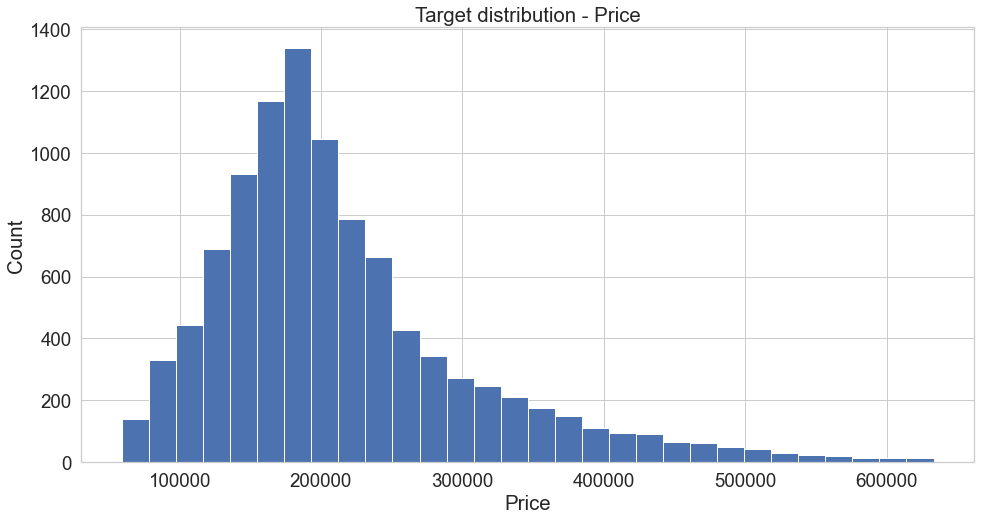

In [42]:
target_name = 'Price'

plt.figure(figsize = (16, 8))

train_df[target_name].hist(bins=30)
plt.ylabel('Count')
plt.xlabel(target_name)

plt.title('Target distribution - {}'.format(target_name))
plt.show()

**Отбор признаков**

In [43]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'ErrorCounter',
 'KitchenStudio',
 'FloorCategory',
 'YearCategory']

In [44]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['ErrorCounter', 'KitchenStudio', 'FloorCategory', 'YearCategory']

**Разбиение на train и test**

In [45]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=MY_RANDOM_STATE)

**Построение модели**

In [46]:
# Обучение

rf_model = RandomForestRegressor(criterion='mse',
                                 n_estimators=400, # кол-во деревьев
                                 max_depth=20, # глубина дерева
                                 min_samples_leaf=5, # минимальное кол-во наблюдений в листе дерева
                                 random_state=MY_RANDOM_STATE
                                )
rf_model.fit(X_train, y_train)

# Был выполнен подбор гиперпараметров класса RandomForestRegressor с использованием GridSearchCV
# Оптимальный набор: 
#    n_estimators=400
#    max_depth=20
#    min_samples_leaf=5

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
           oob_score=False, random_state=29, verbose=0, warm_start=False)

Train R2:	0.869
Test R2:	0.715


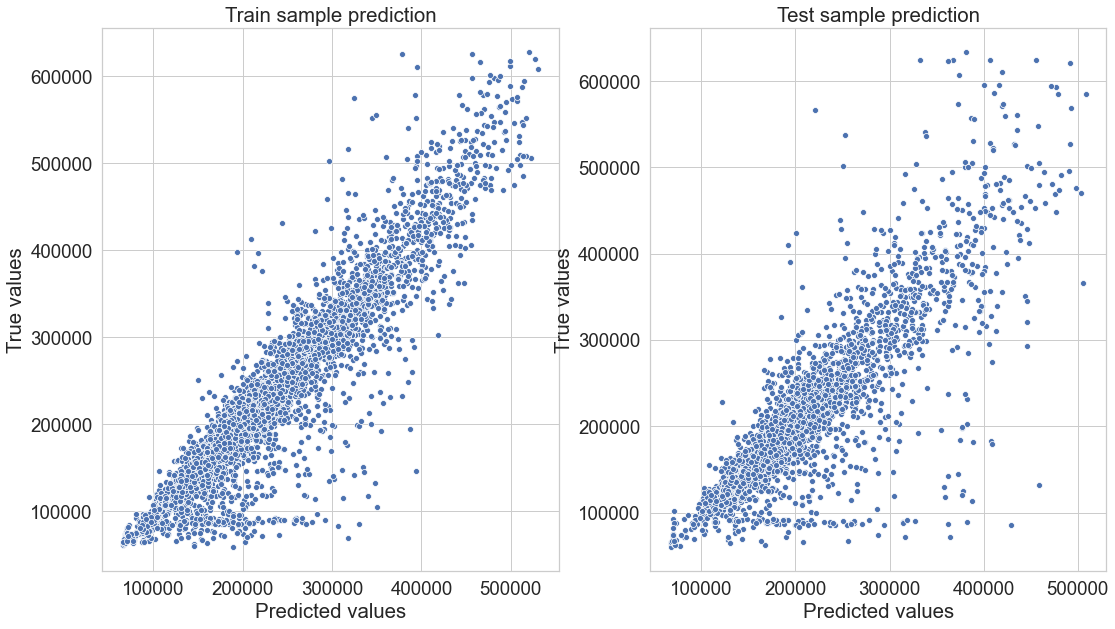

In [47]:
# Оценка модели

y_train_predict = rf_model.predict(X_train)
y_test_predict = rf_model.predict(X_test)

evaluate_predict(y_train, y_train_predict, y_test, y_test_predict)

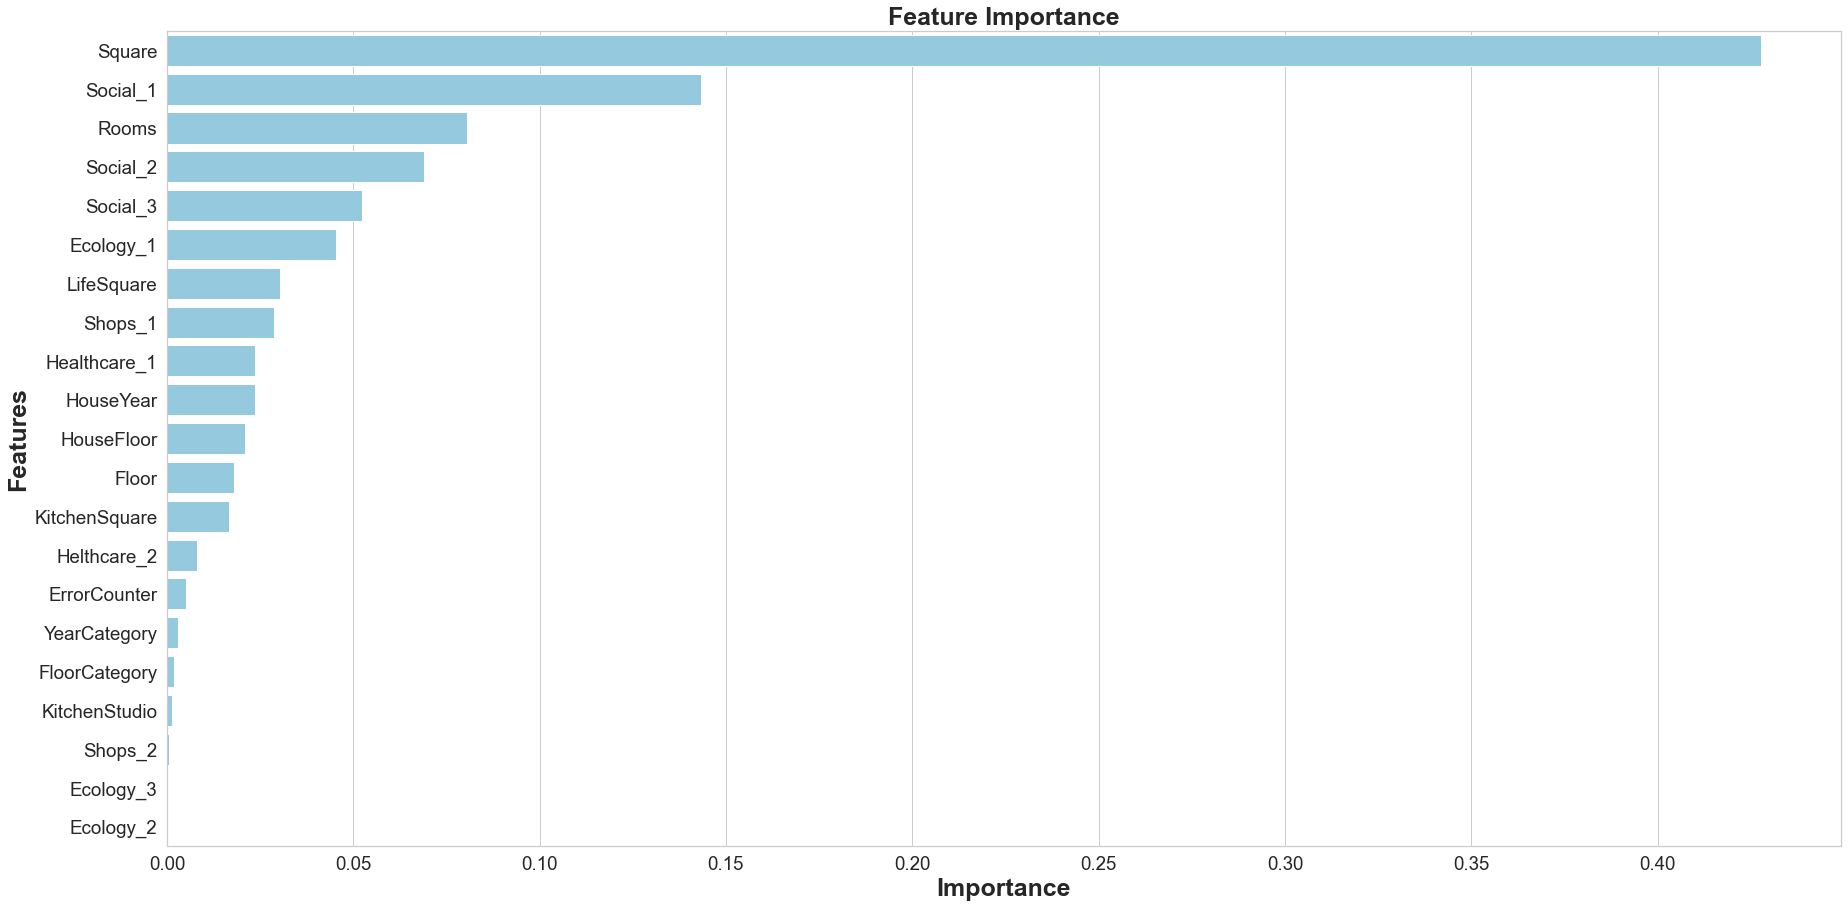

None

,Features,Importance
0,Square,0.427807
1,Social_1,0.143182
2,Rooms,0.080501
3,Social_2,0.068922
4,Social_3,0.052404
5,Ecology_1,0.045377
6,LifeSquare,0.030226
7,Shops_1,0.028639
8,Healthcare_1,0.023610
9,HouseYear,0.023580


In [48]:
# Важность признаков

display_important_features(X_train, rf_model)

**Прогноз на валидационном наборе данных**

In [49]:
valid_df = pd.read_csv(VALID_DATASET_PATH, delimiter=',')
valid_df.shape

(5000, 19)

In [50]:
valid_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [51]:
valid_df = preprocessor.reduce_mem_usage(valid_df, 'test')
valid_df = preprocessor.transform(valid_df)
valid_df.shape

Memory usage of test dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


(5000, 21)

In [52]:
valid_df = features_gen.transform(valid_df)
valid_df.shape

(5000, 23)

In [53]:
valid_df.isnull().sum().sum()

0

In [54]:
valid_df = valid_df[feature_names + new_feature_names]

In [55]:
predictions = rf_model.predict(valid_df)
predictions

array([151684.23174184, 116794.2395279 , 139015.91684272, ...,
       145897.69121376, 193746.03062685, 281414.94808937])

In [56]:
# Запись результатов предсказания в файл

submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [57]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,151684.231742
1,5925,116794.239528
2,960,139015.916843
3,3848,124643.241806
4,746,214780.222062


In [58]:
submit.to_csv('rf_submit.csv', index=False)